In [58]:
from __future__ import print_function, division
import os
import time
import torch
import torch.nn as nn
from  torch import optim 
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.modules.loss import BCEWithLogitsLoss
from torchvision.transforms.functional import pad
import cv2
import torchvision
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torchvision import transforms
from torchvision import models
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [59]:
final = pd.read_csv('mapping/final_dataset.csv')

In [60]:
final['banana'] = int(0)
final.loc[final['is_banana'] == True, 'banana'] = int(1)

In [61]:
final_small = final.sample(80)
final_small

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id,banana
2556,Carlos_Vera_Arteaga_RGB_9_7600_3800_11600_7800...,3798.987793,3356.783447,3994.090332,3576.535156,0.250230,Carlos_Vera_Arteaga_RGB,9,7600,3800,...,Carlos_Vera_Arteaga_RGB,9781.758690,4745.529257,7.957729,cacao,0.0,7.338873,2.862161,55,0
2737,Carlos_Vera_Arteaga_RGB_14_11297_7600_15297_11...,1388.489014,588.804138,1619.846924,811.402466,0.226428,Carlos_Vera_Arteaga_RGB,14,11297,7600,...,Carlos_Vera_Arteaga_RGB,10725.007067,5192.375181,7.957729,cacao,0.0,7.338873,2.862161,343,0
2258,Carlos_Vera_Arteaga_RGB_1_0_3800_4000_7800.png,2245.637207,189.500717,2425.461914,398.555664,0.420311,Carlos_Vera_Arteaga_RGB,1,0,3800,...,Carlos_Vera_Arteaga_RGB,5501.450224,4228.720919,7.957729,cacao,0.0,7.338873,2.862161,147,0
4487,Nestor_Macias_RGB_7_3800_9024_7800_13024.png,2799.093750,240.458115,3013.745605,473.270203,0.619395,Nestor_Macias_RGB,7,3800,9024,...,Nestor_Macias_RGB,8097.592490,8597.978186,12.191240,timber,0.0,46.554370,18.156204,289,0
1808,Carlos_Vera_Guevara_RGB_9_7600_3800_11600_7800...,7.006835,2511.511475,194.761673,2719.028564,0.208947,Carlos_Vera_Guevara_RGB,9,7600,3800,...,Carlos_Vera_Guevara_RGB,7809.423771,5264.259042,7.161956,fruit,0.0,14.037297,5.474546,555,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,Carlos_Vera_Guevara_RGB_1_0_3800_4000_7800.png,2577.906982,2588.482422,2889.549072,2928.502930,0.237943,Carlos_Vera_Guevara_RGB,1,0,3800,...,Carlos_Vera_Guevara_RGB,4161.664638,5875.143040,6.620830,fruit,0.0,11.407983,4.449113,494,0
1638,Carlos_Vera_Guevara_RGB_5_3800_3800_7800_7800.png,2328.472900,3619.717041,2516.525879,3797.427734,0.231827,Carlos_Vera_Guevara_RGB,5,3800,3800,...,Carlos_Vera_Guevara_RGB,6935.666967,6066.224798,8.276038,fruit,0.0,20.561334,8.018920,543,0
1993,Carlos_Vera_Guevara_RGB_5_3800_3800_7800_7800.png,1243.168091,3025.891602,1480.433350,3249.232178,0.342633,Carlos_Vera_Guevara_RGB,5,3800,3800,...,Carlos_Vera_Guevara_RGB,6279.560774,5755.053140,2.546473,cacao,130.0,0.768823,0.299841,738,0
1958,Carlos_Vera_Guevara_RGB_5_3800_3800_7800_7800.png,277.997162,2622.401611,498.763885,2845.084229,0.582590,Carlos_Vera_Guevara_RGB,5,3800,3800,...,Carlos_Vera_Guevara_RGB,5514.985413,5788.592601,6.684492,fruit,0.0,11.699858,4.562945,562,0


In [83]:
#train, trees_test = train_test_split(final, shuffle = True, random_state = 900, test_size = 0.2)

In [63]:
trees_train, trees_valid = train_test_split(final_small, shuffle = True, random_state = 900, test_size = 0.3, 
                                           stratify=final_small.banana.values)

In [64]:
trees_train

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id,banana
358,Carlos_Vera_Arteaga_RGB_0_0_0_4000_4000.png,2579.547852,3524.658203,2759.131592,3713.515381,0.457870,Carlos_Vera_Arteaga_RGB,0,0,0,...,Carlos_Vera_Arteaga_RGB,5984.648342,4562.824865,14.323911,banana,0.0,8.700266,3.393104,80,1
2330,Carlos_Vera_Arteaga_RGB_10_7600_7600_11600_116...,3158.924805,2668.011963,3387.607178,2892.110840,0.264175,Carlos_Vera_Arteaga_RGB,10,7600,7600,...,Carlos_Vera_Arteaga_RGB,8381.044002,7800.591782,5.570410,citrus,0.0,7.230063,2.819725,28,0
3425,Leonor_Aspiazu_RGB_5_3800_3800_7800_7800.png,3204.374268,2767.783691,3374.620850,2945.250488,0.250892,Leonor_Aspiazu_RGB,5,3800,3800,...,Leonor_Aspiazu_RGB,8098.776099,7215.853346,12.732366,other,0.0,41.899895,16.340959,165,0
3839,Manuel_Macias_RGB_3_3800_0_7800_4000.png,1233.352051,1080.747681,1569.699219,1398.727661,0.308814,Manuel_Macias_RGB,3,3800,0,...,Manuel_Macias_RGB,7074.936325,4146.716169,3.183091,cacao,131.0,1.195937,0.466415,279,0
1589,Carlos_Vera_Guevara_RGB_5_3800_3800_7800_7800.png,1577.958008,2855.729980,1766.749390,3060.469727,0.538570,Carlos_Vera_Guevara_RGB,5,3800,3800,...,Carlos_Vera_Guevara_RGB,6371.240625,5700.272022,6.843647,citrus,0.0,12.449709,4.855386,410,0
1135,Manuel_Macias_RGB_1_0_3800_4000_7800.png,2564.115234,1794.522827,2745.658936,1992.401245,0.436511,Manuel_Macias_RGB,1,0,3800,...,Manuel_Macias_RGB,4804.597203,5268.993985,11.459129,banana,0.0,5.408965,2.109496,79,1
1046,Manuel_Macias_RGB_8_7600_6879_11600_10879.png,6.235418,1023.694580,240.994522,1403.153198,0.373165,Manuel_Macias_RGB,8,7600,6879,...,Manuel_Macias_RGB,8743.350662,7600.855529,2.387319,banana,0.0,0.191457,0.074668,68,1
1797,Carlos_Vera_Guevara_RGB_9_7600_3800_11600_7800...,373.205109,1112.701904,853.028503,1596.858398,0.610435,Carlos_Vera_Guevara_RGB,9,7600,3800,...,Carlos_Vera_Guevara_RGB,8151.010075,4640.797745,8.148714,fruit,0.0,19.736728,7.697324,582,0
982,Leonor_Aspiazu_RGB_10_7600_7600_11600_11600.png,3183.261719,35.642838,3434.117676,295.388916,0.401389,Leonor_Aspiazu_RGB,10,7600,7600,...,Leonor_Aspiazu_RGB,11348.368366,7738.400430,10.981665,banana,0.0,4.940200,1.926678,200,1
2976,Flora_Pluas_RGB_10_7600_0_11600_4000.png,2424.998779,664.426392,2761.278564,1000.047119,0.519257,Flora_Pluas_RGB,10,7600,0,...,Flora_Pluas_RGB,8459.733394,3914.190370,6.652661,fruit,0.0,11.553348,4.505806,390,0


In [65]:
# make the training set
trees_train.to_csv('mapping/train_small.csv', index = False) 

In [66]:
# make the validation set
trees_valid.to_csv('mapping/valid_small.csv', index = False) 

In [88]:
# make the test set
#trees_test.to_csv('mapping/test.csv', index = False) 

In [67]:
trees_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 358 to 915
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   img_path          56 non-null     object 
 1   xmin              56 non-null     float64
 2   ymin              56 non-null     float64
 3   xmax              56 non-null     float64
 4   ymax              56 non-null     float64
 5   score             56 non-null     float64
 6   img_name          56 non-null     object 
 7   tile_index        56 non-null     int64  
 8   tile_xmin         56 non-null     int64  
 9   tile_ymin         56 non-null     int64  
 10  tile_xmax         56 non-null     int64  
 11  tile_ymax         56 non-null     int64  
 12  x                 56 non-null     float64
 13  y                 56 non-null     float64
 14  Xmin              56 non-null     float64
 15  Ymin              56 non-null     float64
 16  Xmax              56 non-null     float64
 

In [12]:
trees_train['group'].value_counts()

cacao     24
banana    21
fruit      7
citrus     2
timber     1
other      1
Name: group, dtype: int64

In [13]:
trees_train['site'].value_counts()

Flora_Pluas_RGB            11
Carlos_Vera_Guevara_RGB    11
Carlos_Vera_Arteaga_RGB    11
Manuel_Macias_RGB          11
Leonor_Aspiazu_RGB          7
Nestor_Macias_RGB           5
Name: site, dtype: int64

In [14]:
trees_valid['group'].value_counts()

banana    9
fruit     7
cacao     6
citrus    1
timber    1
Name: group, dtype: int64

In [15]:
trees_valid['site'].value_counts()

Flora_Pluas_RGB            7
Carlos_Vera_Arteaga_RGB    6
Carlos_Vera_Guevara_RGB    6
Leonor_Aspiazu_RGB         3
Nestor_Macias_RGB          2
Name: site, dtype: int64

<Axes: >

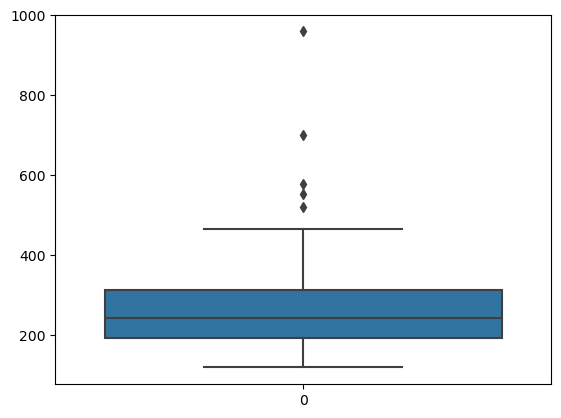

In [16]:
h = trees_train['ymax'].values - trees_train['ymin'].values

# Boxplot of bbox heights
sns.boxplot(h)

<Axes: >

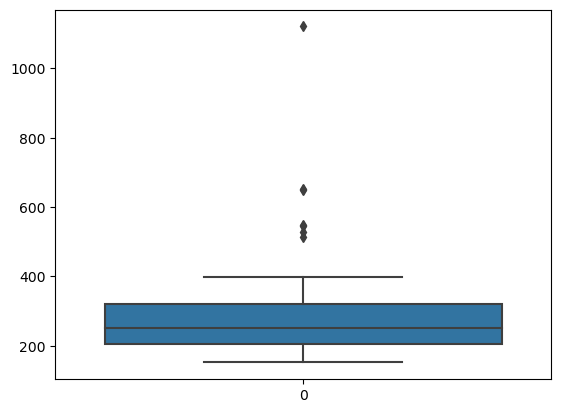

In [17]:
w = trees_train['xmax'].values - trees_train['xmin'].values

# Boxplot of bbox widths
sns.boxplot(w)

<Axes: >

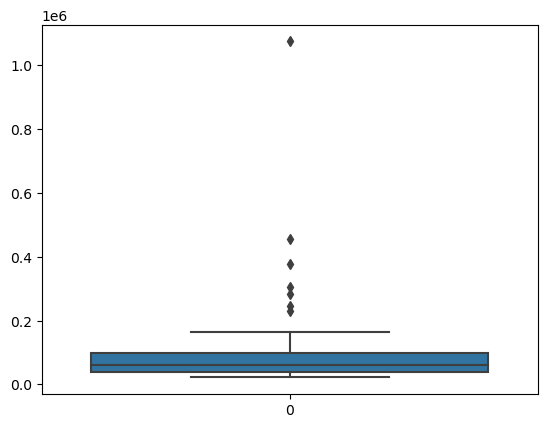

In [18]:
area = h * w

# Boxplot of bbox widths
sns.boxplot(area)
# Area can vary by 2 orders of magnitude, 
#we need to resize the images to be of similar sizes

In [68]:
trees_train.loc[trees_train['ymax'] - trees_train['ymin'] > 800]

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id,banana


In [69]:
trees_train.loc[trees_train['group']=='banana']

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id,banana
358,Carlos_Vera_Arteaga_RGB_0_0_0_4000_4000.png,2579.547852,3524.658203,2759.131592,3713.515381,0.457870,Carlos_Vera_Arteaga_RGB,0,0,0,...,Carlos_Vera_Arteaga_RGB,5984.648342,4562.824865,14.323911,banana,0.0,8.700266,3.393104,80,1
1135,Manuel_Macias_RGB_1_0_3800_4000_7800.png,2564.115234,1794.522827,2745.658936,1992.401245,0.436511,Manuel_Macias_RGB,1,0,3800,...,Manuel_Macias_RGB,4804.597203,5268.993985,11.459129,banana,0.0,5.408965,2.109496,79,1
1046,Manuel_Macias_RGB_8_7600_6879_11600_10879.png,6.235418,1023.694580,240.994522,1403.153198,0.373165,Manuel_Macias_RGB,8,7600,6879,...,Manuel_Macias_RGB,8743.350662,7600.855529,2.387319,banana,0.0,0.191457,0.074668,68,1
982,Leonor_Aspiazu_RGB_10_7600_7600_11600_11600.png,3183.261719,35.642838,3434.117676,295.388916,0.401389,Leonor_Aspiazu_RGB,10,7600,7600,...,Leonor_Aspiazu_RGB,11348.368366,7738.400430,10.981665,banana,0.0,4.940200,1.926678,200,1
1279,Nestor_Macias_RGB_13_11003_3800_15003_7800.png,2387.549805,2.498231,2684.940430,302.435516,0.487098,Nestor_Macias_RGB,13,11003,3800,...,Nestor_Macias_RGB,10932.786306,5917.571000,14.164757,banana,0.0,8.495651,3.313304,85,1
929,Leonor_Aspiazu_RGB_13_11400_3800_15400_7800.png,2.538099,947.670593,229.240738,1298.803101,0.413912,Leonor_Aspiazu_RGB,13,11400,3800,...,Leonor_Aspiazu_RGB,11646.319037,4942.530341,20.690094,banana,0.0,19.041244,7.426085,79,1
647,Flora_Pluas_RGB_7_3800_7600_7800_11600.png,764.037720,3708.099365,1097.373047,3998.926025,0.495700,Flora_Pluas_RGB,7,3800,7600,...,Flora_Pluas_RGB,6075.120492,8070.333326,16.329259,banana,0.0,11.501112,4.485434,314,1
645,Flora_Pluas_RGB_7_3800_7600_7800_11600.png,3146.354736,2426.665771,3461.125488,2763.739014,0.544264,Flora_Pluas_RGB,7,3800,7600,...,Flora_Pluas_RGB,7469.612187,7600.327718,13.687293,banana,0.0,7.897282,3.079940,239,1
1293,Nestor_Macias_RGB_13_11003_3800_15003_7800.png,2943.457031,2452.424072,3197.006104,2690.284180,0.252239,Nestor_Macias_RGB,13,11003,3800,...,Nestor_Macias_RGB,11747.785469,6392.192983,14.164757,banana,0.0,8.495651,3.313304,54,1
1202,Nestor_Macias_RGB_12_11003_0_15003_4000.png,642.711609,1946.898926,896.842163,2194.563232,0.230009,Nestor_Macias_RGB,12,11003,0,...,Nestor_Macias_RGB,9868.345119,4869.279095,10.185893,banana,0.0,4.208810,1.641436,156,1


In [70]:
n = 15
img_name = trees_train.iloc[n, 0]
print(img_name)

Carlos_Vera_Guevara_RGB_3_0_8305_4000_12305.png


In [71]:
df_img1 = trees_train.loc[trees_train['img_path'] == img_name]
tile1 = io.imread(os.path.join('tiles/all_tiles/', img_name))

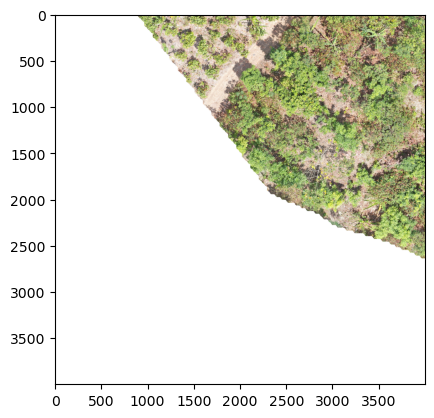

In [72]:
plt.imshow(tile1)
plt.show()

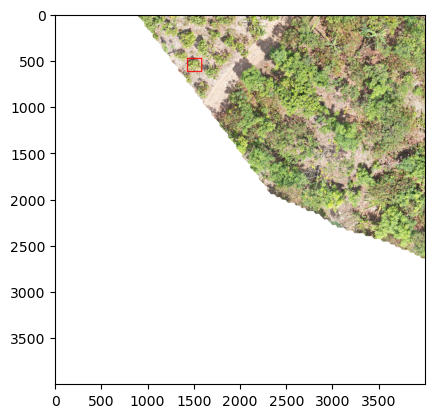

In [73]:
i = 0
for name in df_img1['img_path'].values:
    
    xmin = round(df_img1['xmin'].values[i])
    ymin = round(df_img1['ymin'].values[i])
    xmax = round(df_img1['xmax'].values[i])
    ymax = round(df_img1['ymax'].values[i])

    color = (255,0,0)
    
    tile1 = cv2.rectangle(tile1,(xmin,ymin),(xmax,ymax),color,10)
    
    i += 1
    #break

plt.imshow(tile1)   

In [75]:
def center_crop(img, dim):
	"""Returns center cropped image
	Args:
	img: image to be center cropped
	dim: dimensions (width, height) to be cropped
	"""
	width, height = img.shape[1], img.shape[0]

	# process crop width and height for max available dimension
	crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
	crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
	mid_x, mid_y = int(width/2), int(height/2)
	cw2, ch2 = int(crop_width/2), int(crop_height/2) 
	crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
	return crop_img

In [74]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [76]:
preprocess = transforms.Compose([
                     #NewPad(),
                     #transforms.RandomResizedCrop(224),
                     transforms.Resize(224),
                     transforms.RandomHorizontalFlip(),
                     transforms.ToTensor()
                     #transforms.Resize(224)
                     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
                

In [77]:
class Trees(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.trees_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.trees_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.trees_frame.iloc[idx, 0])
        image = Image.open(img_name)
        
        xmin = int(self.trees_frame.iloc[idx]['xmin'])
        ymin = int(self.trees_frame.iloc[idx]['ymin'])
        xmax = int(self.trees_frame.iloc[idx]['xmax'])
        ymax = int(self.trees_frame.iloc[idx]['ymax'])

        image = image.crop((xmin, ymin, xmax, ymax))
        image = expand2square(image, (0, 0, 0))
        image = preprocess(image)
        #image = image[round(ymin):round(ymax)+1, round(xmin):round(xmax)+1]
        #image = center_crop(image, [800, 800])
        
        #border_height = round((800 - image.shape[0]) / 2)
        #border_width  = round((800 - image.shape[1]) / 2)
        
        #image = cv2.copyMakeBorder(image, border_height, border_height, border_width, border_width, cv2.BORDER_CONSTANT, None, value = 0)
        
        is_banana = self.trees_frame.iloc[idx]['banana']
        
        #image = Image.fromarray(image)
        
        #image = transforms.Resize(224)

        
        sample = image, int(is_banana)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [79]:
ttrain = Trees(csv_file='mapping/train_small.csv', root_dir='tiles/all_tiles')

In [140]:
imgs = torch.stack([img_t for img_t, _ in ttrain], dim=3)

In [141]:
imgs.view(3, -1).mean(dim=1)

tensor([-1.7483, -1.6299, -1.5157])

In [142]:
imgs.view(3, -1).std(dim=1)

tensor([0.9770, 1.0642, 0.7892])

In [80]:
tvalid = Trees(csv_file='mapping/valid_small.csv', root_dir='tiles/all_tiles')

(array([0.42982036, 0.05587   , 0.31263284, 0.70013556, 1.2603636 ,
        1.55844723, 1.61684263, 1.79189211, 1.7385476 , 0.53544843]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

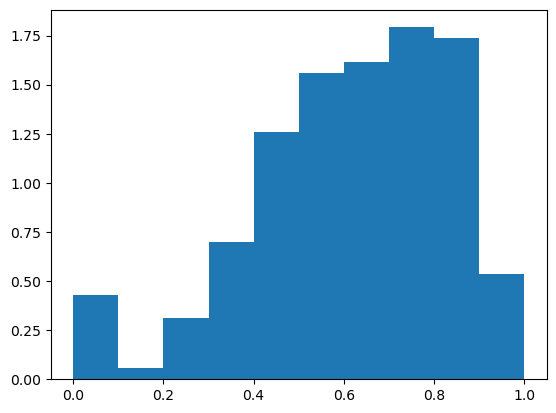

In [81]:
plt.hist(ttrain[0][0].ravel(), density=True)

(array([0.60819249, 0.08470185, 0.42889027, 1.02519139, 1.50516856,
        1.26129328, 1.41820842, 1.76883993, 1.6707861 , 0.22872816]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

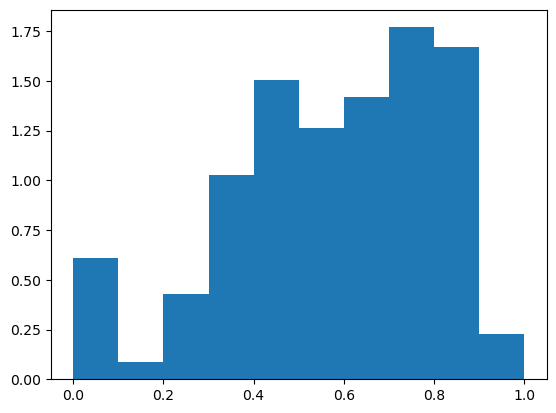

In [82]:
plt.hist(tvalid[0][0].ravel(), density=True)

is_banana: 1


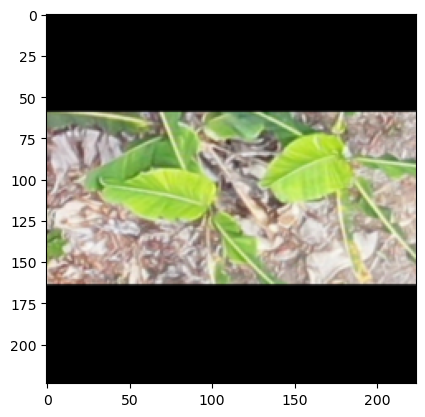

In [83]:
im, label = ttrain[50]
plt.imshow(im.permute(1,2,0))
print('is_banana:',label)

is_banana: 0


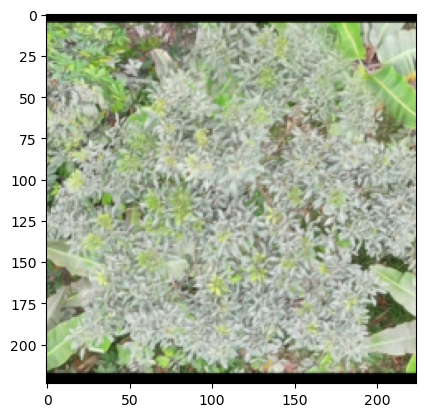

In [84]:
im, label = tvalid[20]
plt.imshow(im.permute(1,2,0))
print('is_banana:',label)

In [85]:
for i in range(len(ttrain)):
    sample = ttrain[i]

    print(i, sample[0].shape, sample[1])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) 1
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0


In [ ]:
# Wrap it onto a dataloader

In [86]:
train_dataloader = DataLoader(ttrain, batch_size=32, shuffle=True)

In [87]:
valid_dataloader = DataLoader(tvalid, batch_size=32, shuffle=False)

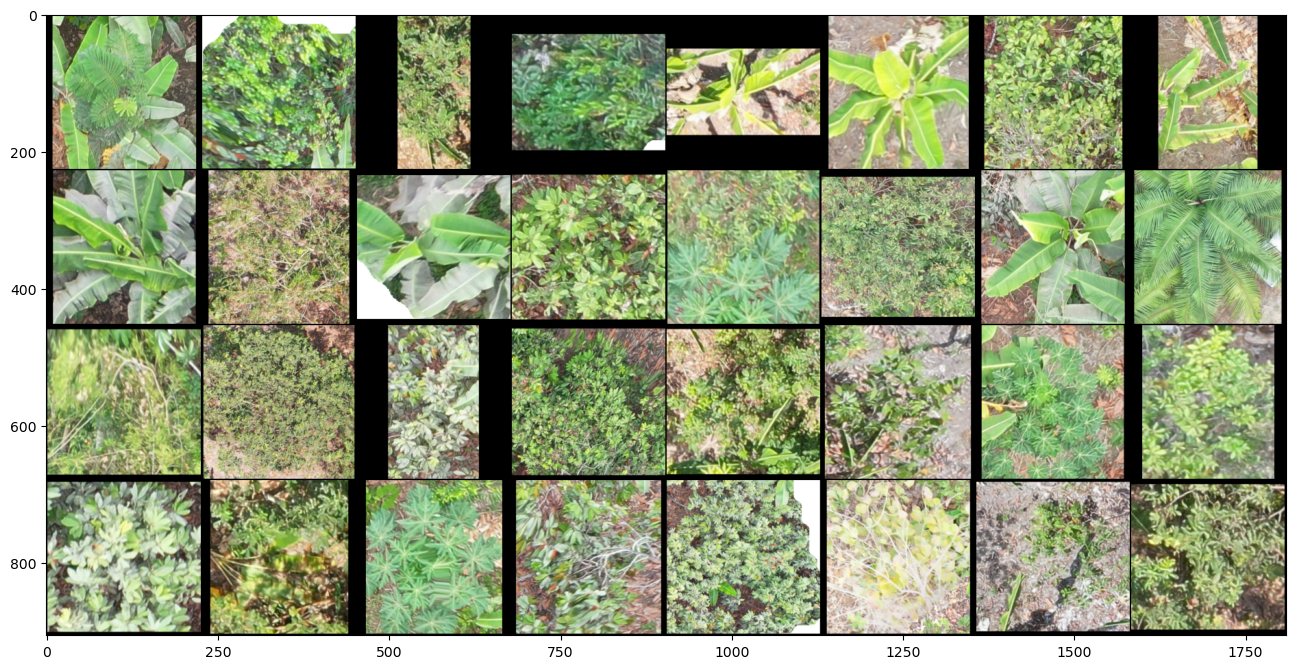

In [88]:
samples, labels = next(iter(train_dataloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:32])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [89]:
print(len(train_dataloader), len(valid_dataloader))

2 1


In [90]:
print('Train dataset size:', len(ttrain))

Train dataset size: 56


In [91]:
model = models.resnet18(pretrained=True)

In [ ]:
# Below, we train resnet18 for with our images

In [93]:
#def set_parameter_requires_grad(model, feature_extracting=True):
#    if feature_extracting:
#        for param in model.parameters():
#            param.requires_grad = False
            
#set_parameter_requires_grad(resnet18, False)

In [94]:
#modelOutputFeats = model.fc.in_features
#modelOutputFeats

In [43]:
# Initialize new final output layer
#model.fc = nn.Linear(modelOutputFeats, 1)

model.fc = nn.Sequential(
     nn.Dropout(0.5),
     nn.Linear(512, 1)
)

#fc = nn.Sequential(OrderedDict([
#    ('fc1', nn.Linear(512,100)),
#    ('relu', nn.ReLU()),
#    ('fc2', nn.Linear(100,2)),
#    ('output', nn.LogSoftmax(dim=1))
#]))

#model.fc = fc

In [44]:
optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay= 1e-3)
#optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Setup the loss function
criterion = BCEWithLogitsLoss()

In [95]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [47]:
train_loss = []
train_acc = []

val_loss = []
val_acc = []

epochs = 20

if torch.cuda.is_available():
    model.cuda()

for epoch in range(epochs):
      print("epoch {}/{}".format(epoch+1,epochs))
      running_loss = 0.0
      running_score = 0.0
#       model.train()
      for image,label in train_dataloader:
          image, label = image.to(device), label.to(device)
          label = label.unsqueeze(1)
          optimizer.zero_grad()
          y_pred = model(image)
          #print(y_pred)
          #print(label)
          loss = criterion(y_pred,label.float())  
          #print('y_pred', y_pred)
          #print('label', label)
          loss.backward() #calculate derivatives 
          optimizer.step() # update parameters
          #y_np = y_pred.cpu().numpy()

          #val, index_ = torch.max(y_pred,axis=1)
          #index = np.zeros(len(y_np))
          index = torch.where(y_pred > 0.0, 1, 0)
          #print(index)
          #class1 = y_pred > 0.0

          #print(class1)
          #class2 = y_pred <= 0.0

          #index_ = index.cpu().numpy()
          #print(index)
          #print(y_pred)
          #print(class1_)
          #class1_ = class1.cpu().numpy()
          #class2_ = class2.cpu().numpy()
          
          #index_[class1_] = 1
          #index_[class2_] = 0

          #index_ = torch.from_numpy(index)
                
          running_score += torch.sum(index == label.data).item()
          running_loss += loss.item()
      
      epoch_score = running_score/len(train_dataloader.dataset)
      epoch_loss = running_loss/len(train_dataloader.dataset)
      train_loss.append(epoch_loss)
      train_acc.append(epoch_score)
      print("Training loss: {}, accuracy: {}".format(epoch_loss,epoch_score))
      #print("Training loss: {}".format(epoch_loss))
      
      with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for image,label in valid_dataloader:
                image = image.to(device)
                label = label.to(device)
                label = label.unsqueeze(1)
                optimizer.zero_grad()
                y_pred = model(image)
                loss = criterion(y_pred,label.float())
                running_loss += loss.item()
                #y_np = y_pred.cpu().numpy()

                #val, index_ = torch.max(y_pred,axis=1)
                index = torch.where(y_pred > 0, 1, 0)
                #index = torch.zeros(y_pred.size(dim = 0))
                #class1 = y_np > 0.0
                #class2 = y_np <= 0.0

                #index[class1] = 1
                #index[class2] = 0
                
                running_score += torch.sum(index == label.data).item()
          
          epoch_score = running_score/len(valid_dataloader.dataset)
          epoch_loss = running_loss/len(valid_dataloader.dataset)
          val_loss.append(epoch_loss)
          val_acc.append(epoch_score)
          print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))
         # print("Validation loss: {}".format(epoch_loss))


epoch 1/20
Training loss: 0.025929846933909824, accuracy: 0.5357142857142857
Validation loss: 0.0291631817817688, accuracy: 0.375
epoch 2/20
Training loss: 0.018603503704071045, accuracy: 0.5892857142857143
Validation loss: 0.011597769955794016, accuracy: 0.8333333333333334
epoch 3/20
Training loss: 0.009154405178768294, accuracy: 0.9107142857142857
Validation loss: 0.0037543606013059616, accuracy: 1.0
epoch 4/20
Training loss: 0.003596669661679438, accuracy: 0.9642857142857143
Validation loss: 0.007103050748507182, accuracy: 0.9166666666666666
epoch 5/20
Training loss: 0.0008747851742165429, accuracy: 1.0
Validation loss: 0.002337343990802765, accuracy: 1.0
epoch 6/20
Training loss: 0.000659066967533103, accuracy: 1.0
Validation loss: 0.0036625899374485016, accuracy: 0.9583333333333334
epoch 7/20
Training loss: 0.00013772054808214307, accuracy: 1.0
Validation loss: 0.00970770294467608, accuracy: 0.875
epoch 8/20
Training loss: 0.0004219919542915055, accuracy: 1.0
Validation loss: 0.00

In [50]:
epochs = range(1, 21, 1)

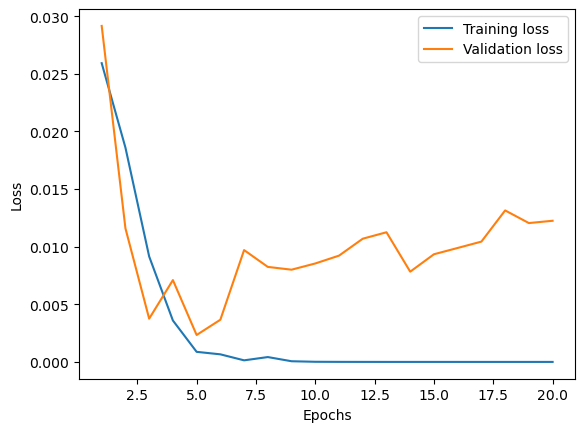

In [51]:
plt.plot(epochs, train_loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

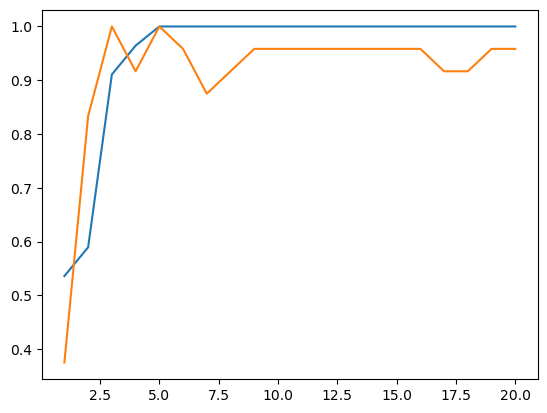

In [52]:
plt.plot(epochs, train_acc, label = 'Training accuracy')
plt.plot(epochs, val_acc, label = 'Training accuracy')